In [1]:
#=============================================================================
# Modules
#=============================================================================

# Standard modules
import yaml
import os
import numpy as np
import torch
import torch.optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Custom modules
from logger import logger
from data_preprocessing import combine_label_files
import dataset
from resnet50 import ResNet50, Residual_block

#=============================================================================
# Variables
#=============================================================================

dataset_directory = "../data/processed/1.5mmRegions/mph/"
label_directory = "../data/processed/1.5mmRegions/labels/"
model_name = "testing_model"
output_directory = "../outputs/"

# Path to the JSON metadata file
configuration_file_path = "../config/model.yaml"

# Set seed
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

#=============================================================================
# Functions
#=============================================================================

def get_label_dict(labels: list):
    """generates a dictionary of a list of labels where the keys are class numberings

    Args:
        labels (list): list of labels

    Returns:
        dict: dictionary of labels with class numberings
    """
    label_dict = {}
    for i, label in enumerate(labels):
       label_dict[i] = label
    return label_dict

def evaluate(model:torch.nn.Sequential, testloader:torch.utils.data.DataLoader, device: object):
    """returns the lists of actual labels, predictions, probabilities

    Args:
        model (object): PyTorch model to do predictions on data 
        testloader (object): Dataloader object with test data
        device (object): Device to put pytorch objects on

    Returns:
        list, list, list: lists of actual labels, predictions, probabilities
    """    
    # Set model to evaluation mode
    model.to(device)
    model.eval()
    
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get probabilities
            probs = F.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            
            # Get predicted class
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            
            # Store true labels
            all_labels.extend(labels.cpu().numpy())
            
    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    return all_labels, all_preds, all_probs

def get_ROC(all_labels:list, all_preds:list, all_probs:list, file:str):
    """Generates and saves ROC (Receiver Operating Characteristic) curves for a multi-class classification problem.

    Args:
        all_labels (list): True class labels for all samples.
        all_preds (list): Predicted class labels for all samples.
        all_probs (list): Predicted probabilities for each class (should be a 2D array with shape [n_samples, n_classes]).
        file (str): The filename (without extension) where the ROC curve plot will be saved.

    Returns:
        None: The function saves the plot to a file and does not return any value.

    """    
    # Binarize the labels for ROC and AUC calculation
    n_classes = all_probs.shape[1]
    all_labels_bin = label_binarize(all_labels, classes=np.arange(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    linestyles = ['-', '-.', ':']  # Define different linestyles

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve for each class
    plt.figure()

    for i in range(n_classes):
        linestyle = linestyles[i % len(linestyles)]  # Cycle through linestyles if n_classes > len(linestyles)
        plt.plot(fpr[i], tpr[i], linestyle=linestyle, color="black", lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.4f})')

    # Plot micro-average ROC curve
    plt.plot(fpr["micro"], tpr["micro"], color='black', linestyle='--', linewidth=2, label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.4f})')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', rotation=0, ha='right', fontsize=16)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
    plt.savefig(f"{file}.pdf", format='pdf', dpi=300, bbox_inches='tight')
    return None

#==========================================================================
# Configuration imports
#==========================================================================

with open(configuration_file_path, "r") as file:
    configuration_data = yaml.safe_load(file)

# Extract model configurations
logger.info(f"importing model configurations...")
gpu                        = configuration_data["gpu"]
test_ratio                 = configuration_data["test_ratio"]
batch_size                 = configuration_data["batch_size"]
supervised                 = configuration_data["supervised"]
in_channels                = configuration_data["in_channels"]
num_classes                = configuration_data["num_classes"]

# Extract training configurations:
logger.info(f"importing training configurations...")
epochs       = configuration_data["training"]["epochs"]
lr           = configuration_data["training"]["optimiser"]["lr"]
beta         = configuration_data["training"]["optimiser"]["beta"]
weight_decay = configuration_data["training"]["optimiser"]["weight_decay"]
temperature  = configuration_data["training"]["loss"]["temperature"]
mode         = configuration_data["training"]["scheduler"]["mode"]
factor       = configuration_data["training"]["scheduler"]["factor"]
patience     = configuration_data["training"]["scheduler"]["patience"]
threshold    = configuration_data["training"]["scheduler"]["threshold"]
min_lr       = configuration_data["training"]["scheduler"]["min_lr"]

#==========================================================================
# Output directories
#==========================================================================

models_directory_path      = f"{output_directory}models/"
training_directory_path    = f"{output_directory}training/"
summaries_directory_path   = f"{output_directory}evaluations/"

#==========================================================================
# Checking output directory exists
#==========================================================================

logger.info(f"Checking output model directory...")
if not os.path.exists(models_directory_path):
        os.makedirs(models_directory_path)
        
logger.info(f"Checking output training directory...")
if not os.path.exists(training_directory_path):
        os.makedirs(training_directory_path)
        
logger.info(f"Checking output evalutions directory...")
if not os.path.exists(summaries_directory_path):
        os.makedirs(summaries_directory_path)
        
#==========================================================================
# Set device
#==========================================================================

if gpu is True:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

2024-08-27 12:01:55,852 - mph_pipeline_logger - INFO - importing model configurations...
2024-08-27 12:01:55,853 - mph_pipeline_logger - INFO - importing training configurations...
2024-08-27 12:01:55,854 - mph_pipeline_logger - INFO - Checking output model directory...
2024-08-27 12:01:55,856 - mph_pipeline_logger - INFO - Checking output training directory...
2024-08-27 12:01:55,857 - mph_pipeline_logger - INFO - Checking output evalutions directory...


In [2]:
#======================================================================
#  Data set generation
#======================================================================

# Image size for images to be loaded into dataset
if supervised is True:
    image_size = 64
else:
    image_size = 128

# Generate data set objects
logger.info(f"Generating supervised data set...")
labels = combine_label_files(label_directory)
label_dict = get_label_dict(labels)
model_dataset = dataset.Labelled_dataset(dataset_directory, label_dict, transform=dataset.get_transform(image_size=image_size))
    
# Split to test and training data sets
logger.info(f"Splitting data set...")
train_dataset, test_dataset = dataset.split_dataset(model_dataset, test_ratio)

# Normalise data set
logger.info(f"Calculating normalisation parameters...")
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
mean, std = dataset.calculate_mean_std(trainloader)

# Dataloading
logger.info(f"Generating dataloader objects...")
transform = dataset.get_transform(mean=mean, std=std, image_size=image_size)
train_dataset.dataset.transform = transform
test_dataset.dataset.transform = transform
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

2024-08-27 12:01:59,730 - mph_pipeline_logger - INFO - Generating supervised data set...
2024-08-27 12:01:59,743 - mph_pipeline_logger - INFO - Files to be processed found
2024-08-27 12:01:59,778 - mph_pipeline_logger - INFO - Labels found successfully
2024-08-27 12:01:59,798 - mph_pipeline_logger - INFO - Labels found successfully
2024-08-27 12:01:59,812 - mph_pipeline_logger - INFO - Labels found successfully
2024-08-27 12:01:59,839 - mph_pipeline_logger - INFO - Splitting data set...
2024-08-27 12:01:59,844 - mph_pipeline_logger - INFO - Calculating normalisation parameters...
2024-08-27 12:02:21,568 - mph_pipeline_logger - INFO - Generating dataloader objects...


In [3]:
# Show class label allocations
label_dict

{0: 'CD8', 1: 'FoxP3', 2: 'CD68'}

  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 44.97% 


Training loss 1.13 | Test loss 1.10 | Training accuracy: 40.85% | Test accuracy: 44.97% | learning rate 0.010000000:  10%|█         | 1/10 [01:18<11:42, 78.06s/it]

Test accuracy: 41.82% 


Training loss 1.15 | Test loss 1.13 | Training accuracy: 39.20% | Test accuracy: 41.82% | learning rate 0.010000000:  20%|██        | 2/10 [01:51<06:53, 51.64s/it]

Test accuracy: 48.11% 


Training loss 1.09 | Test loss 1.06 | Training accuracy: 44.38% | Test accuracy: 48.11% | learning rate 0.010000000:  30%|███       | 3/10 [02:24<05:03, 43.37s/it]

Test accuracy: 39.94% 


Training loss 1.12 | Test loss 1.13 | Training accuracy: 42.50% | Test accuracy: 39.94% | learning rate 0.010000000:  40%|████      | 4/10 [02:58<03:56, 39.43s/it]

Test accuracy: 44.65% 


Training loss 1.09 | Test loss 1.07 | Training accuracy: 43.99% | Test accuracy: 44.65% | learning rate 0.010000000:  50%|█████     | 5/10 [03:34<03:11, 38.36s/it]

Test accuracy: 54.09% 


Training loss 1.03 | Test loss 1.00 | Training accuracy: 49.49% | Test accuracy: 54.09% | learning rate 0.010000000:  60%|██████    | 6/10 [04:09<02:28, 37.10s/it]

Test accuracy: 51.89% 


Training loss 1.02 | Test loss 1.01 | Training accuracy: 51.92% | Test accuracy: 51.89% | learning rate 0.010000000:  70%|███████   | 7/10 [04:43<01:48, 36.04s/it]

Test accuracy: 57.55% 


Training loss 1.01 | Test loss 0.98 | Training accuracy: 51.85% | Test accuracy: 57.55% | learning rate 0.010000000:  80%|████████  | 8/10 [05:16<01:10, 35.34s/it]

Test accuracy: 57.23% 


Training loss 0.99 | Test loss 0.98 | Training accuracy: 53.81% | Test accuracy: 57.23% | learning rate 0.010000000:  90%|█████████ | 9/10 [05:51<00:34, 34.98s/it]

Test accuracy: 55.66% 


Training loss 1.00 | Test loss 0.96 | Training accuracy: 53.34% | Test accuracy: 55.66% | learning rate 0.010000000: 100%|██████████| 10/10 [06:25<00:00, 38.51s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 52.83% 


Training loss 1.05 | Test loss 0.99 | Training accuracy: 46.90% | Test accuracy: 52.83% | learning rate 0.010000000:  10%|█         | 1/10 [00:32<04:52, 32.54s/it]

Test accuracy: 57.23% 


Training loss 1.04 | Test loss 0.98 | Training accuracy: 50.51% | Test accuracy: 57.23% | learning rate 0.010000000:  20%|██        | 2/10 [01:05<04:22, 32.87s/it]

Test accuracy: 50.31% 


Training loss 1.03 | Test loss 1.03 | Training accuracy: 50.90% | Test accuracy: 50.31% | learning rate 0.010000000:  30%|███       | 3/10 [01:38<03:49, 32.85s/it]

Test accuracy: 57.86% 


Training loss 1.02 | Test loss 0.96 | Training accuracy: 51.77% | Test accuracy: 57.86% | learning rate 0.010000000:  40%|████      | 4/10 [02:11<03:18, 33.04s/it]

Test accuracy: 60.69% 


Training loss 1.00 | Test loss 0.94 | Training accuracy: 53.97% | Test accuracy: 60.69% | learning rate 0.010000000:  50%|█████     | 5/10 [02:43<02:43, 32.68s/it]

Test accuracy: 54.40% 


Training loss 0.99 | Test loss 1.00 | Training accuracy: 55.46% | Test accuracy: 54.40% | learning rate 0.010000000:  60%|██████    | 6/10 [03:16<02:10, 32.66s/it]

Test accuracy: 56.29% 


Training loss 1.00 | Test loss 0.98 | Training accuracy: 54.12% | Test accuracy: 56.29% | learning rate 0.010000000:  70%|███████   | 7/10 [03:49<01:38, 32.72s/it]

Test accuracy: 53.46% 


Training loss 0.99 | Test loss 1.00 | Training accuracy: 55.38% | Test accuracy: 53.46% | learning rate 0.010000000:  80%|████████  | 8/10 [04:22<01:05, 32.85s/it]

Test accuracy: 61.64% 


Training loss 0.98 | Test loss 0.93 | Training accuracy: 56.09% | Test accuracy: 61.64% | learning rate 0.010000000:  90%|█████████ | 9/10 [04:55<00:32, 32.79s/it]

Test accuracy: 59.75% 


Training loss 0.96 | Test loss 0.93 | Training accuracy: 57.11% | Test accuracy: 59.75% | learning rate 0.010000000: 100%|██████████| 10/10 [05:27<00:00, 32.80s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 47.17% 


Training loss 1.05 | Test loss 1.06 | Training accuracy: 46.27% | Test accuracy: 47.17% | learning rate 0.010000000:  10%|█         | 1/10 [00:32<04:50, 32.29s/it]

Test accuracy: 53.46% 


Training loss 1.03 | Test loss 1.00 | Training accuracy: 50.51% | Test accuracy: 53.46% | learning rate 0.010000000:  20%|██        | 2/10 [01:03<04:13, 31.71s/it]

Test accuracy: 58.49% 


Training loss 1.00 | Test loss 0.96 | Training accuracy: 54.44% | Test accuracy: 58.49% | learning rate 0.010000000:  30%|███       | 3/10 [01:34<03:40, 31.44s/it]

Test accuracy: 56.92% 


Training loss 1.00 | Test loss 0.96 | Training accuracy: 53.73% | Test accuracy: 56.92% | learning rate 0.010000000:  40%|████      | 4/10 [02:06<03:08, 31.40s/it]

Test accuracy: 57.23% 


Training loss 0.97 | Test loss 0.97 | Training accuracy: 56.64% | Test accuracy: 57.23% | learning rate 0.010000000:  50%|█████     | 5/10 [02:36<02:36, 31.22s/it]

Test accuracy: 58.18% 


Training loss 0.95 | Test loss 0.96 | Training accuracy: 59.31% | Test accuracy: 58.18% | learning rate 0.010000000:  60%|██████    | 6/10 [03:08<02:04, 31.18s/it]

Test accuracy: 58.81% 


Training loss 0.95 | Test loss 0.95 | Training accuracy: 59.23% | Test accuracy: 58.81% | learning rate 0.010000000:  70%|███████   | 7/10 [03:38<01:33, 31.08s/it]

Test accuracy: 58.18% 


Training loss 0.93 | Test loss 0.95 | Training accuracy: 61.04% | Test accuracy: 58.18% | learning rate 0.010000000:  80%|████████  | 8/10 [04:09<01:01, 31.00s/it]

Test accuracy: 54.72% 


Training loss 0.92 | Test loss 0.98 | Training accuracy: 61.90% | Test accuracy: 54.72% | learning rate 0.010000000:  90%|█████████ | 9/10 [04:41<00:31, 31.31s/it]

Test accuracy: 56.60% 


Training loss 0.92 | Test loss 0.97 | Training accuracy: 62.53% | Test accuracy: 56.60% | learning rate 0.010000000: 100%|██████████| 10/10 [05:13<00:00, 31.36s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 34.28% 


Training loss 1.08 | Test loss 1.10 | Training accuracy: 40.22% | Test accuracy: 34.28% | learning rate 0.010000000:  10%|█         | 1/10 [00:31<04:43, 31.49s/it]

Test accuracy: 53.14% 


Training loss 1.01 | Test loss 1.03 | Training accuracy: 51.85% | Test accuracy: 53.14% | learning rate 0.010000000:  20%|██        | 2/10 [01:03<04:14, 31.76s/it]

Test accuracy: 49.69% 


Training loss 0.98 | Test loss 1.02 | Training accuracy: 55.93% | Test accuracy: 49.69% | learning rate 0.010000000:  30%|███       | 3/10 [01:34<03:40, 31.54s/it]

Test accuracy: 56.92% 


Training loss 0.98 | Test loss 0.95 | Training accuracy: 55.62% | Test accuracy: 56.92% | learning rate 0.010000000:  40%|████      | 4/10 [02:07<03:11, 31.87s/it]

Test accuracy: 56.92% 


Training loss 0.96 | Test loss 0.97 | Training accuracy: 58.05% | Test accuracy: 56.92% | learning rate 0.010000000:  50%|█████     | 5/10 [02:38<02:37, 31.60s/it]

Test accuracy: 55.35% 


Training loss 0.96 | Test loss 0.96 | Training accuracy: 57.89% | Test accuracy: 55.35% | learning rate 0.010000000:  60%|██████    | 6/10 [03:09<02:06, 31.61s/it]

Test accuracy: 56.60% 


Training loss 0.95 | Test loss 0.96 | Training accuracy: 59.31% | Test accuracy: 56.60% | learning rate 0.010000000:  70%|███████   | 7/10 [03:41<01:34, 31.49s/it]

Test accuracy: 53.46% 


Training loss 0.91 | Test loss 0.98 | Training accuracy: 62.22% | Test accuracy: 53.46% | learning rate 0.010000000:  80%|████████  | 8/10 [04:12<01:02, 31.44s/it]

Test accuracy: 60.69% 


Training loss 0.88 | Test loss 0.92 | Training accuracy: 66.93% | Test accuracy: 60.69% | learning rate 0.010000000:  90%|█████████ | 9/10 [04:44<00:31, 31.51s/it]

Test accuracy: 53.77% 


Training loss 0.86 | Test loss 0.97 | Training accuracy: 68.03% | Test accuracy: 53.77% | learning rate 0.010000000: 100%|██████████| 10/10 [05:15<00:00, 31.51s/it]


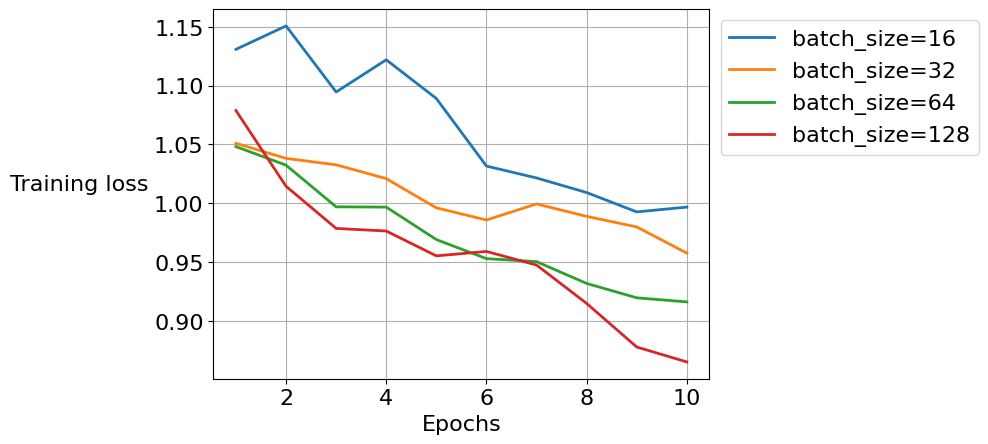

In [3]:
# batch_size experiment
batch_sizes = [16, 32, 64, 128]
losses = []

for batch_size in batch_sizes:
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    Resnet50 = ResNet50(block=Residual_block, in_channels=in_channels, num_classes=num_classes).to(device)
    optimizer = torch.optim.SGD(Resnet50.parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss, _ = Resnet50.train_model(train_data=trainloader, test_data=testloader, criterion=torch.nn.CrossEntropyLoss(), optimizer=optimizer, device=device, curve_path=f"{training_directory_path}{model_name}_supervised_batch_size_{batch_size}_experiment", epochs=epochs)
    losses.append(loss)

plt.figure()
for i, loss in enumerate(losses):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'batch_size={batch_sizes[i]}')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/supervised_batch_size_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 35.53% 


Training loss 1.10 | Test loss 1.18 | Training accuracy: 42.34% | Test accuracy: 35.53% | learning rate 0.100000000:  10%|█         | 1/10 [00:32<04:55, 32.78s/it]

Test accuracy: 27.36% 


Training loss 1.13 | Test loss 1.27 | Training accuracy: 41.08% | Test accuracy: 27.36% | learning rate 0.100000000:  20%|██        | 2/10 [01:04<04:18, 32.37s/it]

Test accuracy: 47.17% 


Training loss 1.16 | Test loss 1.06 | Training accuracy: 37.78% | Test accuracy: 47.17% | learning rate 0.100000000:  30%|███       | 3/10 [01:36<03:44, 32.09s/it]

Test accuracy: 47.80% 


Training loss 1.10 | Test loss 1.06 | Training accuracy: 44.15% | Test accuracy: 47.80% | learning rate 0.100000000:  40%|████      | 4/10 [02:07<03:09, 31.65s/it]

Test accuracy: 48.74% 


Training loss 1.09 | Test loss 1.04 | Training accuracy: 45.33% | Test accuracy: 48.74% | learning rate 0.100000000:  50%|█████     | 5/10 [02:39<02:38, 31.65s/it]

Test accuracy: 50.00% 


Training loss 1.08 | Test loss 1.04 | Training accuracy: 46.66% | Test accuracy: 50.00% | learning rate 0.100000000:  60%|██████    | 6/10 [03:11<02:07, 31.88s/it]

Test accuracy: 45.28% 


Training loss 1.09 | Test loss 1.07 | Training accuracy: 45.25% | Test accuracy: 45.28% | learning rate 0.100000000:  70%|███████   | 7/10 [03:42<01:35, 31.73s/it]

Test accuracy: 34.28% 


Training loss 1.07 | Test loss 1.13 | Training accuracy: 46.58% | Test accuracy: 34.28% | learning rate 0.100000000:  80%|████████  | 8/10 [04:14<01:03, 31.55s/it]

Test accuracy: 50.31% 


Training loss 1.08 | Test loss 1.03 | Training accuracy: 46.35% | Test accuracy: 50.31% | learning rate 0.100000000:  90%|█████████ | 9/10 [04:47<00:31, 31.97s/it]

Test accuracy: 49.69% 


Training loss 1.09 | Test loss 1.04 | Training accuracy: 46.11% | Test accuracy: 49.69% | learning rate 0.100000000: 100%|██████████| 10/10 [05:17<00:00, 31.79s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 33.96% 


Training loss 1.06 | Test loss 1.10 | Training accuracy: 43.21% | Test accuracy: 33.96% | learning rate 0.010000000:  10%|█         | 1/10 [00:33<05:00, 33.35s/it]

Test accuracy: 44.97% 


Training loss 1.00 | Test loss 1.04 | Training accuracy: 52.87% | Test accuracy: 44.97% | learning rate 0.010000000:  20%|██        | 2/10 [01:07<04:28, 33.62s/it]

Test accuracy: 53.14% 


Training loss 0.98 | Test loss 0.98 | Training accuracy: 55.62% | Test accuracy: 53.14% | learning rate 0.010000000:  30%|███       | 3/10 [01:39<03:51, 33.07s/it]

Test accuracy: 55.97% 


Training loss 0.97 | Test loss 0.96 | Training accuracy: 57.03% | Test accuracy: 55.97% | learning rate 0.010000000:  40%|████      | 4/10 [02:11<03:14, 32.43s/it]

Test accuracy: 58.49% 


Training loss 0.96 | Test loss 0.94 | Training accuracy: 57.82% | Test accuracy: 58.49% | learning rate 0.010000000:  50%|█████     | 5/10 [02:43<02:42, 32.43s/it]

Test accuracy: 57.86% 


Training loss 0.92 | Test loss 0.93 | Training accuracy: 61.67% | Test accuracy: 57.86% | learning rate 0.010000000:  60%|██████    | 6/10 [03:15<02:08, 32.17s/it]

Test accuracy: 57.23% 


Training loss 0.91 | Test loss 0.96 | Training accuracy: 62.77% | Test accuracy: 57.23% | learning rate 0.010000000:  70%|███████   | 7/10 [03:46<01:35, 31.85s/it]

Test accuracy: 53.77% 


Training loss 0.90 | Test loss 0.97 | Training accuracy: 63.63% | Test accuracy: 53.77% | learning rate 0.010000000:  80%|████████  | 8/10 [04:18<01:03, 31.83s/it]

Test accuracy: 56.92% 


Training loss 0.88 | Test loss 0.96 | Training accuracy: 66.54% | Test accuracy: 56.92% | learning rate 0.010000000:  90%|█████████ | 9/10 [04:50<00:31, 31.90s/it]

Test accuracy: 53.77% 


Training loss 0.87 | Test loss 0.99 | Training accuracy: 67.71% | Test accuracy: 53.77% | learning rate 0.010000000: 100%|██████████| 10/10 [05:22<00:00, 32.30s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 34.28% 


Training loss 1.11 | Test loss 1.10 | Training accuracy: 34.01% | Test accuracy: 34.28% | learning rate 0.001000000:  10%|█         | 1/10 [00:32<04:53, 32.66s/it]

Test accuracy: 33.02% 


Training loss 1.06 | Test loss 1.10 | Training accuracy: 45.25% | Test accuracy: 33.02% | learning rate 0.001000000:  20%|██        | 2/10 [01:04<04:16, 32.05s/it]

Test accuracy: 34.59% 


Training loss 1.02 | Test loss 1.09 | Training accuracy: 53.50% | Test accuracy: 34.59% | learning rate 0.001000000:  30%|███       | 3/10 [01:35<03:43, 31.86s/it]

Test accuracy: 47.80% 


Training loss 0.97 | Test loss 1.03 | Training accuracy: 58.05% | Test accuracy: 47.80% | learning rate 0.001000000:  40%|████      | 4/10 [02:08<03:13, 32.22s/it]

Test accuracy: 56.92% 


Training loss 0.94 | Test loss 0.98 | Training accuracy: 61.43% | Test accuracy: 56.92% | learning rate 0.001000000:  50%|█████     | 5/10 [02:40<02:40, 32.04s/it]

Test accuracy: 58.81% 


Training loss 0.90 | Test loss 0.95 | Training accuracy: 67.95% | Test accuracy: 58.81% | learning rate 0.001000000:  60%|██████    | 6/10 [03:10<02:05, 31.39s/it]

Test accuracy: 57.86% 


Training loss 0.84 | Test loss 0.96 | Training accuracy: 74.63% | Test accuracy: 57.86% | learning rate 0.001000000:  70%|███████   | 7/10 [03:40<01:32, 30.95s/it]

Test accuracy: 57.86% 


Training loss 0.78 | Test loss 0.96 | Training accuracy: 82.72% | Test accuracy: 57.86% | learning rate 0.001000000:  80%|████████  | 8/10 [04:10<01:01, 30.66s/it]

Test accuracy: 54.40% 


Training loss 0.73 | Test loss 0.98 | Training accuracy: 87.51% | Test accuracy: 54.40% | learning rate 0.001000000:  90%|█████████ | 9/10 [04:40<00:30, 30.56s/it]

Test accuracy: 54.72% 


Training loss 0.67 | Test loss 0.97 | Training accuracy: 92.62% | Test accuracy: 54.72% | learning rate 0.001000000: 100%|██████████| 10/10 [05:12<00:00, 31.22s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 33.96% 


Training loss 1.11 | Test loss 1.10 | Training accuracy: 35.11% | Test accuracy: 33.96% | learning rate 0.000100000:  10%|█         | 1/10 [00:31<04:39, 31.10s/it]

Test accuracy: 33.96% 


Training loss 1.09 | Test loss 1.11 | Training accuracy: 40.06% | Test accuracy: 33.96% | learning rate 0.000100000:  20%|██        | 2/10 [01:01<04:03, 30.45s/it]

Test accuracy: 33.96% 


Training loss 1.06 | Test loss 1.10 | Training accuracy: 48.15% | Test accuracy: 33.96% | learning rate 0.000100000:  30%|███       | 3/10 [01:31<03:34, 30.65s/it]

Test accuracy: 38.68% 


Training loss 1.03 | Test loss 1.09 | Training accuracy: 56.95% | Test accuracy: 38.68% | learning rate 0.000100000:  40%|████      | 4/10 [02:02<03:04, 30.70s/it]

Test accuracy: 48.74% 


Training loss 1.00 | Test loss 1.07 | Training accuracy: 64.96% | Test accuracy: 48.74% | learning rate 0.000100000:  50%|█████     | 5/10 [02:33<02:33, 30.79s/it]

Test accuracy: 49.69% 


Training loss 0.98 | Test loss 1.06 | Training accuracy: 72.19% | Test accuracy: 49.69% | learning rate 0.000100000:  60%|██████    | 6/10 [03:03<02:02, 30.58s/it]

Test accuracy: 52.83% 


Training loss 0.96 | Test loss 1.05 | Training accuracy: 75.57% | Test accuracy: 52.83% | learning rate 0.000100000:  70%|███████   | 7/10 [03:34<01:31, 30.57s/it]

Test accuracy: 53.14% 


Training loss 0.93 | Test loss 1.04 | Training accuracy: 79.89% | Test accuracy: 53.14% | learning rate 0.000100000:  80%|████████  | 8/10 [04:04<01:00, 30.44s/it]

Test accuracy: 52.83% 


Training loss 0.91 | Test loss 1.04 | Training accuracy: 81.85% | Test accuracy: 52.83% | learning rate 0.000100000:  90%|█████████ | 9/10 [04:34<00:30, 30.35s/it]

Test accuracy: 54.72% 


Training loss 0.88 | Test loss 1.04 | Training accuracy: 86.88% | Test accuracy: 54.72% | learning rate 0.000100000: 100%|██████████| 10/10 [05:05<00:00, 30.53s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 34.28% 


Training loss 1.10 | Test loss 1.10 | Training accuracy: 35.27% | Test accuracy: 34.28% | learning rate 0.000010000:  10%|█         | 1/10 [00:30<04:30, 30.04s/it]

Test accuracy: 30.50% 


Training loss 1.10 | Test loss 1.10 | Training accuracy: 35.19% | Test accuracy: 30.50% | learning rate 0.000010000:  20%|██        | 2/10 [01:00<04:00, 30.10s/it]

Test accuracy: 31.76% 


Training loss 1.10 | Test loss 1.10 | Training accuracy: 36.21% | Test accuracy: 31.76% | learning rate 0.000010000:  30%|███       | 3/10 [01:31<03:34, 30.71s/it]

Test accuracy: 31.76% 


Training loss 1.09 | Test loss 1.10 | Training accuracy: 36.61% | Test accuracy: 31.76% | learning rate 0.000010000:  40%|████      | 4/10 [02:01<03:02, 30.43s/it]

Test accuracy: 29.56% 


Training loss 1.09 | Test loss 1.10 | Training accuracy: 37.78% | Test accuracy: 29.56% | learning rate 0.000010000:  50%|█████     | 5/10 [02:31<02:31, 30.21s/it]

Test accuracy: 31.76% 


Training loss 1.08 | Test loss 1.11 | Training accuracy: 38.88% | Test accuracy: 31.76% | learning rate 0.000010000:  60%|██████    | 6/10 [03:01<02:00, 30.05s/it]

Test accuracy: 31.76% 


Training loss 1.08 | Test loss 1.11 | Training accuracy: 40.30% | Test accuracy: 31.76% | learning rate 0.000010000:  70%|███████   | 7/10 [03:30<01:29, 29.93s/it]

Test accuracy: 33.02% 


Training loss 1.07 | Test loss 1.11 | Training accuracy: 41.40% | Test accuracy: 33.02% | learning rate 0.000010000:  80%|████████  | 8/10 [04:01<01:00, 30.09s/it]

Test accuracy: 32.70% 


Training loss 1.07 | Test loss 1.10 | Training accuracy: 42.18% | Test accuracy: 32.70% | learning rate 0.000010000:  90%|█████████ | 9/10 [04:31<00:30, 30.23s/it]

Test accuracy: 32.70% 


Training loss 1.07 | Test loss 1.10 | Training accuracy: 44.30% | Test accuracy: 32.70% | learning rate 0.000010000: 100%|██████████| 10/10 [05:01<00:00, 30.20s/it]


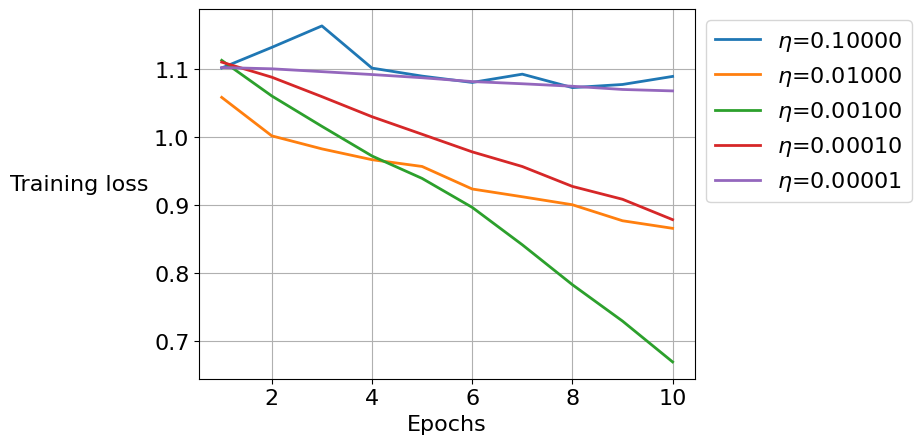

In [4]:
# lr experiment
batch_size = 128
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]
losses = []

for lr in lrs:
    Resnet50 = ResNet50(block=Residual_block, in_channels=in_channels, num_classes=num_classes).to(device)
    optimizer = torch.optim.SGD(Resnet50.parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss, _ = Resnet50.train_model(train_data=trainloader, test_data=testloader, criterion=torch.nn.CrossEntropyLoss(), optimizer=optimizer, device=device, curve_path=f"{training_directory_path}{model_name}_supervised_learning_rate_{lr:}_experiment", epochs=epochs)
    losses.append(loss)

plt.figure()
for i, loss in enumerate(losses):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'$\eta$={lrs[i]:.5f}')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/supervised_learning_rate_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 34.28% 


Training loss 1.10 | Test loss 1.10 | Training accuracy: 34.49% | Test accuracy: 34.28% | learning rate 0.001000000:  10%|█         | 1/10 [00:32<04:49, 32.17s/it]

Test accuracy: 34.91% 


Training loss 1.06 | Test loss 1.10 | Training accuracy: 51.06% | Test accuracy: 34.91% | learning rate 0.001000000:  20%|██        | 2/10 [01:02<04:09, 31.20s/it]

Test accuracy: 33.65% 


Training loss 1.02 | Test loss 1.09 | Training accuracy: 54.44% | Test accuracy: 33.65% | learning rate 0.001000000:  30%|███       | 3/10 [01:33<03:36, 30.88s/it]

Test accuracy: 46.86% 


Training loss 0.99 | Test loss 1.05 | Training accuracy: 57.27% | Test accuracy: 46.86% | learning rate 0.001000000:  40%|████      | 4/10 [02:04<03:05, 30.87s/it]

Test accuracy: 56.60% 


Training loss 0.95 | Test loss 1.00 | Training accuracy: 62.37% | Test accuracy: 56.60% | learning rate 0.001000000:  50%|█████     | 5/10 [02:35<02:34, 30.92s/it]

Test accuracy: 55.35% 


Training loss 0.91 | Test loss 0.99 | Training accuracy: 67.32% | Test accuracy: 55.35% | learning rate 0.001000000:  60%|██████    | 6/10 [03:06<02:03, 31.00s/it]

Test accuracy: 55.66% 


Training loss 0.87 | Test loss 0.98 | Training accuracy: 73.61% | Test accuracy: 55.66% | learning rate 0.001000000:  70%|███████   | 7/10 [03:38<01:34, 31.58s/it]

Test accuracy: 57.55% 


Training loss 0.81 | Test loss 0.98 | Training accuracy: 81.62% | Test accuracy: 57.55% | learning rate 0.001000000:  80%|████████  | 8/10 [04:11<01:03, 31.87s/it]

Test accuracy: 55.97% 


Training loss 0.75 | Test loss 0.98 | Training accuracy: 89.87% | Test accuracy: 55.97% | learning rate 0.001000000:  90%|█████████ | 9/10 [04:42<00:31, 31.75s/it]

Test accuracy: 54.40% 


Training loss 0.69 | Test loss 0.97 | Training accuracy: 94.27% | Test accuracy: 54.40% | learning rate 0.001000000: 100%|██████████| 10/10 [05:14<00:00, 31.43s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 34.28% 


Training loss 1.09 | Test loss 1.10 | Training accuracy: 36.92% | Test accuracy: 34.28% | learning rate 0.001000000:  10%|█         | 1/10 [00:31<04:41, 31.33s/it]

Test accuracy: 33.96% 


Training loss 1.04 | Test loss 1.10 | Training accuracy: 51.92% | Test accuracy: 33.96% | learning rate 0.001000000:  20%|██        | 2/10 [01:04<04:19, 32.44s/it]

Test accuracy: 33.96% 


Training loss 0.99 | Test loss 1.10 | Training accuracy: 57.50% | Test accuracy: 33.96% | learning rate 0.001000000:  30%|███       | 3/10 [01:36<03:47, 32.43s/it]

Test accuracy: 42.14% 


Training loss 0.96 | Test loss 1.04 | Training accuracy: 61.12% | Test accuracy: 42.14% | learning rate 0.001000000:  40%|████      | 4/10 [02:08<03:11, 31.96s/it]

Test accuracy: 53.14% 


Training loss 0.92 | Test loss 1.00 | Training accuracy: 64.73% | Test accuracy: 53.14% | learning rate 0.001000000:  50%|█████     | 5/10 [02:39<02:39, 31.83s/it]

Test accuracy: 56.60% 


Training loss 0.87 | Test loss 0.97 | Training accuracy: 72.51% | Test accuracy: 56.60% | learning rate 0.001000000:  60%|██████    | 6/10 [03:11<02:06, 31.67s/it]

Test accuracy: 54.72% 


Training loss 0.81 | Test loss 0.99 | Training accuracy: 79.81% | Test accuracy: 54.72% | learning rate 0.001000000:  70%|███████   | 7/10 [03:42<01:34, 31.47s/it]

Test accuracy: 55.35% 


Training loss 0.75 | Test loss 0.98 | Training accuracy: 86.80% | Test accuracy: 55.35% | learning rate 0.001000000:  80%|████████  | 8/10 [04:13<01:02, 31.32s/it]

Test accuracy: 52.52% 


Training loss 0.69 | Test loss 0.99 | Training accuracy: 91.67% | Test accuracy: 52.52% | learning rate 0.001000000:  90%|█████████ | 9/10 [04:44<00:31, 31.19s/it]

Test accuracy: 51.26% 


Training loss 0.65 | Test loss 1.00 | Training accuracy: 95.52% | Test accuracy: 51.26% | learning rate 0.001000000: 100%|██████████| 10/10 [05:15<00:00, 31.51s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 33.65% 


Training loss 1.12 | Test loss 1.10 | Training accuracy: 33.86% | Test accuracy: 33.65% | learning rate 0.001000000:  10%|█         | 1/10 [00:30<04:33, 30.39s/it]

Test accuracy: 30.50% 


Training loss 1.06 | Test loss 1.10 | Training accuracy: 45.88% | Test accuracy: 30.50% | learning rate 0.001000000:  20%|██        | 2/10 [01:01<04:05, 30.65s/it]

Test accuracy: 34.28% 


Training loss 1.02 | Test loss 1.09 | Training accuracy: 52.32% | Test accuracy: 34.28% | learning rate 0.001000000:  30%|███       | 3/10 [01:31<03:34, 30.61s/it]

Test accuracy: 46.54% 


Training loss 0.97 | Test loss 1.03 | Training accuracy: 57.27% | Test accuracy: 46.54% | learning rate 0.001000000:  40%|████      | 4/10 [02:02<03:04, 30.73s/it]

Test accuracy: 51.57% 


Training loss 0.92 | Test loss 1.00 | Training accuracy: 64.41% | Test accuracy: 51.57% | learning rate 0.001000000:  50%|█████     | 5/10 [02:33<02:33, 30.78s/it]

Test accuracy: 53.77% 


Training loss 0.87 | Test loss 0.98 | Training accuracy: 71.25% | Test accuracy: 53.77% | learning rate 0.001000000:  60%|██████    | 6/10 [03:04<02:03, 30.84s/it]

Test accuracy: 54.09% 


Training loss 0.81 | Test loss 0.98 | Training accuracy: 79.50% | Test accuracy: 54.09% | learning rate 0.001000000:  70%|███████   | 7/10 [03:36<01:33, 31.25s/it]

Test accuracy: 54.09% 


Training loss 0.74 | Test loss 1.00 | Training accuracy: 86.65% | Test accuracy: 54.09% | learning rate 0.001000000:  80%|████████  | 8/10 [04:09<01:03, 31.88s/it]

Test accuracy: 49.69% 


Training loss 0.67 | Test loss 1.00 | Training accuracy: 92.93% | Test accuracy: 49.69% | learning rate 0.001000000:  90%|█████████ | 9/10 [04:41<00:31, 31.90s/it]

Test accuracy: 54.09% 


Training loss 0.62 | Test loss 0.98 | Training accuracy: 96.07% | Test accuracy: 54.09% | learning rate 0.001000000: 100%|██████████| 10/10 [05:13<00:00, 31.33s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 32.39% 


Training loss 1.11 | Test loss 1.10 | Training accuracy: 34.41% | Test accuracy: 32.39% | learning rate 0.001000000:  10%|█         | 1/10 [00:31<04:43, 31.46s/it]

Test accuracy: 33.96% 


Training loss 1.05 | Test loss 1.11 | Training accuracy: 48.31% | Test accuracy: 33.96% | learning rate 0.001000000:  20%|██        | 2/10 [01:03<04:13, 31.73s/it]

Test accuracy: 33.65% 


Training loss 1.00 | Test loss 1.10 | Training accuracy: 52.55% | Test accuracy: 33.65% | learning rate 0.001000000:  30%|███       | 3/10 [01:33<03:37, 31.13s/it]

Test accuracy: 51.57% 


Training loss 0.96 | Test loss 1.01 | Training accuracy: 57.82% | Test accuracy: 51.57% | learning rate 0.001000000:  40%|████      | 4/10 [02:04<03:05, 30.88s/it]

Test accuracy: 56.60% 


Training loss 0.92 | Test loss 0.95 | Training accuracy: 64.41% | Test accuracy: 56.60% | learning rate 0.001000000:  50%|█████     | 5/10 [02:35<02:34, 30.90s/it]

Test accuracy: 58.18% 


Training loss 0.86 | Test loss 0.95 | Training accuracy: 71.56% | Test accuracy: 58.18% | learning rate 0.001000000:  60%|██████    | 6/10 [03:06<02:04, 31.05s/it]

Test accuracy: 53.77% 


Training loss 0.79 | Test loss 0.99 | Training accuracy: 78.40% | Test accuracy: 53.77% | learning rate 0.001000000:  70%|███████   | 7/10 [03:37<01:33, 31.03s/it]

Test accuracy: 55.97% 


Training loss 0.73 | Test loss 0.96 | Training accuracy: 84.21% | Test accuracy: 55.97% | learning rate 0.001000000:  80%|████████  | 8/10 [04:08<01:02, 31.05s/it]

Test accuracy: 51.89% 


Training loss 0.69 | Test loss 1.00 | Training accuracy: 88.53% | Test accuracy: 51.89% | learning rate 0.001000000:  90%|█████████ | 9/10 [04:39<00:30, 30.86s/it]

Test accuracy: 51.89% 


Training loss 0.65 | Test loss 1.00 | Training accuracy: 91.59% | Test accuracy: 51.89% | learning rate 0.001000000: 100%|██████████| 10/10 [05:11<00:00, 31.13s/it]


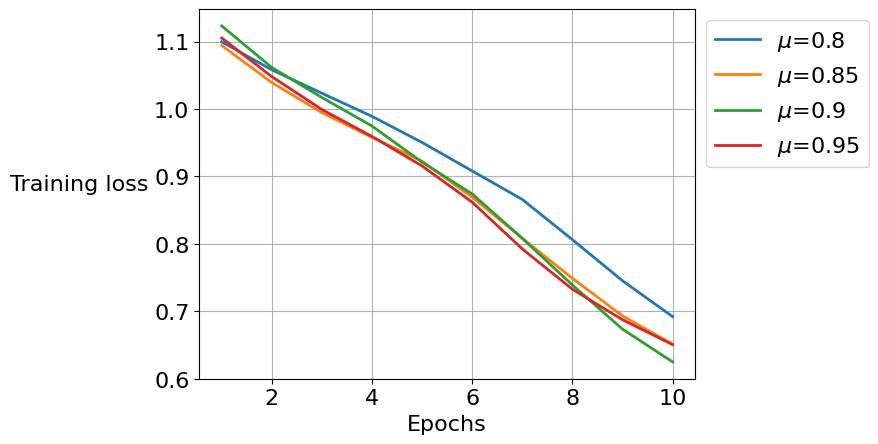

In [5]:
# beta experiment
lr = 0.001
betas = [0.8, 0.85, 0.9, 0.95]
losses = []

for beta in betas:
    Resnet50 = ResNet50(block=Residual_block, in_channels=in_channels, num_classes=num_classes).to(device)
    optimizer = torch.optim.SGD(Resnet50.parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss, _ = Resnet50.train_model(train_data=trainloader, test_data=testloader, criterion=torch.nn.CrossEntropyLoss(), optimizer=optimizer, device=device, curve_path=f"{training_directory_path}{model_name}_supervised_momentum_{beta:}_experiment", epochs=epochs)
    losses.append(loss)

plt.figure()
for i, loss in enumerate(losses):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'$\mu$={betas[i]:}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/supervised_momentum_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 33.96% 


Training loss 1.12 | Test loss 1.10 | Training accuracy: 32.44% | Test accuracy: 33.96% | learning rate 0.001000000:  10%|█         | 1/10 [00:46<06:57, 46.34s/it]

Test accuracy: 33.96% 


Training loss 1.06 | Test loss 1.10 | Training accuracy: 42.97% | Test accuracy: 33.96% | learning rate 0.001000000:  20%|██        | 2/10 [01:17<05:00, 37.51s/it]

Test accuracy: 35.53% 


Training loss 1.01 | Test loss 1.08 | Training accuracy: 51.37% | Test accuracy: 35.53% | learning rate 0.001000000:  30%|███       | 3/10 [01:49<04:04, 34.86s/it]

Test accuracy: 52.52% 


Training loss 0.97 | Test loss 1.00 | Training accuracy: 56.72% | Test accuracy: 52.52% | learning rate 0.001000000:  40%|████      | 4/10 [02:20<03:20, 33.41s/it]

Test accuracy: 57.86% 


Training loss 0.94 | Test loss 0.96 | Training accuracy: 59.94% | Test accuracy: 57.86% | learning rate 0.001000000:  50%|█████     | 5/10 [02:52<02:44, 32.84s/it]

Test accuracy: 56.60% 


Training loss 0.90 | Test loss 0.96 | Training accuracy: 66.85% | Test accuracy: 56.60% | learning rate 0.001000000:  60%|██████    | 6/10 [03:23<02:09, 32.34s/it]

Test accuracy: 54.09% 


Training loss 0.84 | Test loss 0.98 | Training accuracy: 74.55% | Test accuracy: 54.09% | learning rate 0.001000000:  70%|███████   | 7/10 [03:55<01:36, 32.14s/it]

Test accuracy: 54.40% 


Training loss 0.77 | Test loss 0.96 | Training accuracy: 82.17% | Test accuracy: 54.40% | learning rate 0.001000000:  80%|████████  | 8/10 [04:26<01:03, 31.64s/it]

Test accuracy: 54.72% 


Training loss 0.71 | Test loss 0.96 | Training accuracy: 87.51% | Test accuracy: 54.72% | learning rate 0.001000000:  90%|█████████ | 9/10 [04:55<00:31, 31.10s/it]

Test accuracy: 53.14% 


Training loss 0.68 | Test loss 0.97 | Training accuracy: 90.02% | Test accuracy: 53.14% | learning rate 0.001000000: 100%|██████████| 10/10 [05:26<00:00, 32.62s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 37.11% 


Training loss 1.09 | Test loss 1.10 | Training accuracy: 39.04% | Test accuracy: 37.11% | learning rate 0.001000000:  10%|█         | 1/10 [00:29<04:27, 29.78s/it]

Test accuracy: 33.96% 


Training loss 1.04 | Test loss 1.11 | Training accuracy: 49.02% | Test accuracy: 33.96% | learning rate 0.001000000:  20%|██        | 2/10 [00:59<03:58, 29.85s/it]

Test accuracy: 34.91% 


Training loss 1.01 | Test loss 1.11 | Training accuracy: 52.00% | Test accuracy: 34.91% | learning rate 0.001000000:  30%|███       | 3/10 [01:29<03:28, 29.73s/it]

Test accuracy: 48.74% 


Training loss 0.98 | Test loss 1.02 | Training accuracy: 56.17% | Test accuracy: 48.74% | learning rate 0.001000000:  40%|████      | 4/10 [02:01<03:03, 30.61s/it]

Test accuracy: 57.23% 


Training loss 0.94 | Test loss 0.97 | Training accuracy: 60.33% | Test accuracy: 57.23% | learning rate 0.001000000:  50%|█████     | 5/10 [02:33<02:36, 31.27s/it]

Test accuracy: 57.86% 


Training loss 0.90 | Test loss 0.95 | Training accuracy: 66.30% | Test accuracy: 57.86% | learning rate 0.001000000:  60%|██████    | 6/10 [03:05<02:05, 31.37s/it]

Test accuracy: 57.86% 


Training loss 0.84 | Test loss 0.95 | Training accuracy: 74.23% | Test accuracy: 57.86% | learning rate 0.001000000:  70%|███████   | 7/10 [03:36<01:33, 31.33s/it]

Test accuracy: 55.66% 


Training loss 0.78 | Test loss 0.97 | Training accuracy: 79.42% | Test accuracy: 55.66% | learning rate 0.001000000:  80%|████████  | 8/10 [04:07<01:02, 31.12s/it]

Test accuracy: 53.14% 


Training loss 0.74 | Test loss 0.98 | Training accuracy: 82.88% | Test accuracy: 53.14% | learning rate 0.001000000:  90%|█████████ | 9/10 [04:37<00:30, 30.89s/it]

Test accuracy: 56.92% 


Training loss 0.70 | Test loss 0.96 | Training accuracy: 86.72% | Test accuracy: 56.92% | learning rate 0.001000000: 100%|██████████| 10/10 [05:08<00:00, 30.82s/it]
  0%|          | 0/10 [00:00<?, ?it/s]

Test accuracy: 32.70% 


Training loss 1.11 | Test loss 1.10 | Training accuracy: 34.96% | Test accuracy: 32.70% | learning rate 0.001000000:  10%|█         | 1/10 [00:32<04:52, 32.47s/it]

Test accuracy: 33.96% 


Training loss 1.06 | Test loss 1.10 | Training accuracy: 49.73% | Test accuracy: 33.96% | learning rate 0.001000000:  20%|██        | 2/10 [01:06<04:25, 33.21s/it]

Test accuracy: 39.94% 


Training loss 1.01 | Test loss 1.07 | Training accuracy: 51.53% | Test accuracy: 39.94% | learning rate 0.001000000:  30%|███       | 3/10 [01:38<03:48, 32.64s/it]

Test accuracy: 50.63% 


Training loss 0.98 | Test loss 1.00 | Training accuracy: 55.46% | Test accuracy: 50.63% | learning rate 0.001000000:  40%|████      | 4/10 [02:11<03:16, 32.78s/it]

Test accuracy: 58.81% 


Training loss 0.95 | Test loss 0.95 | Training accuracy: 59.70% | Test accuracy: 58.81% | learning rate 0.001000000:  50%|█████     | 5/10 [02:42<02:41, 32.34s/it]

Test accuracy: 59.75% 


Training loss 0.90 | Test loss 0.95 | Training accuracy: 66.06% | Test accuracy: 59.75% | learning rate 0.001000000:  60%|██████    | 6/10 [03:12<02:05, 31.48s/it]

Test accuracy: 55.66% 


Training loss 0.85 | Test loss 0.96 | Training accuracy: 72.82% | Test accuracy: 55.66% | learning rate 0.001000000:  70%|███████   | 7/10 [03:42<01:33, 31.09s/it]

Test accuracy: 57.23% 


Training loss 0.78 | Test loss 0.96 | Training accuracy: 79.89% | Test accuracy: 57.23% | learning rate 0.001000000:  80%|████████  | 8/10 [04:12<01:01, 30.68s/it]

Test accuracy: 53.46% 


Training loss 0.73 | Test loss 0.97 | Training accuracy: 83.74% | Test accuracy: 53.46% | learning rate 0.001000000:  90%|█████████ | 9/10 [04:43<00:30, 30.68s/it]

Test accuracy: 59.43% 


Training loss 0.71 | Test loss 0.95 | Training accuracy: 86.65% | Test accuracy: 59.43% | learning rate 0.001000000: 100%|██████████| 10/10 [05:15<00:00, 31.50s/it]


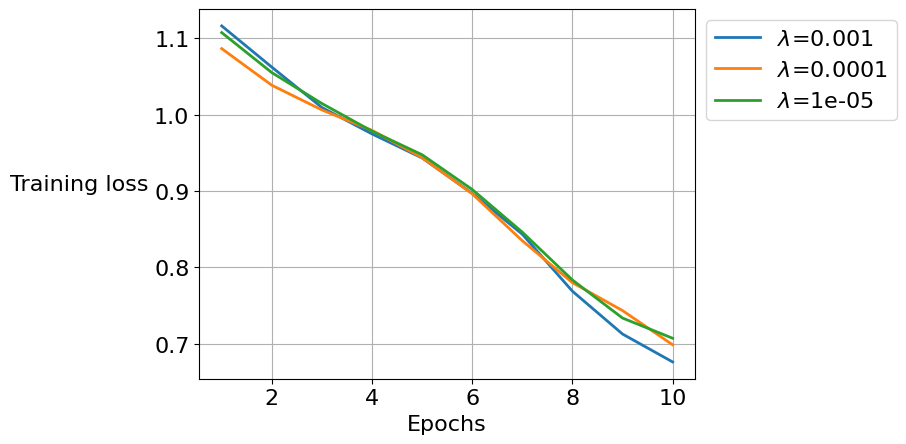

In [6]:
# Weight decay experiment
beta = 0.95
weight_decays = [0.001, 0.0001, 0.00001]
losses = []

for weight_decay in weight_decays:
    Resnet50 = ResNet50(block=Residual_block, in_channels=in_channels, num_classes=num_classes).to(device)
    optimizer = torch.optim.SGD(Resnet50.parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
    loss, _ = Resnet50.train_model(train_data=trainloader, test_data=testloader, criterion=torch.nn.CrossEntropyLoss(), optimizer=optimizer, device=device, curve_path=f"{training_directory_path}{model_name}_supervised_weight_decay_{weight_decay:}_experiment", epochs=epochs)
    losses.append(loss)

plt.figure()
for i, loss in enumerate(losses):
    plt.plot(range(1, epochs + 1), loss,  lw=2, label=f'$\lambda$={weight_decays[i]:}')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Training loss', rotation=0, ha='right', fontsize=16)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
plt.savefig(f"../report/report-images/supervised_weigtht_decay_experiment.pdf", format='pdf', dpi=300, bbox_inches='tight')

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 33.96% 


Training loss 1.11 | Test loss 1.10 | Training accuracy: 35.19% | Test accuracy: 33.96% | learning rate 0.001000000:   1%|          | 1/100 [00:32<53:30, 32.43s/it]

Test accuracy: 33.96% 


Training loss 1.05 | Test loss 1.10 | Training accuracy: 48.86% | Test accuracy: 33.96% | learning rate 0.001000000:   2%|▏         | 2/100 [01:02<51:01, 31.24s/it]

Test accuracy: 43.08% 


Training loss 1.01 | Test loss 1.06 | Training accuracy: 51.92% | Test accuracy: 43.08% | learning rate 0.001000000:   3%|▎         | 3/100 [01:33<50:08, 31.02s/it]

Test accuracy: 51.26% 


Training loss 0.98 | Test loss 1.00 | Training accuracy: 55.85% | Test accuracy: 51.26% | learning rate 0.001000000:   4%|▍         | 4/100 [02:04<49:22, 30.86s/it]

Test accuracy: 57.23% 


Training loss 0.94 | Test loss 0.96 | Training accuracy: 60.96% | Test accuracy: 57.23% | learning rate 0.001000000:   5%|▌         | 5/100 [02:34<48:43, 30.78s/it]

Test accuracy: 57.23% 


Training loss 0.89 | Test loss 0.96 | Training accuracy: 67.01% | Test accuracy: 57.23% | learning rate 0.001000000:   6%|▌         | 6/100 [03:05<48:12, 30.77s/it]

Test accuracy: 52.52% 


Training loss 0.83 | Test loss 0.97 | Training accuracy: 74.63% | Test accuracy: 52.52% | learning rate 0.001000000:   7%|▋         | 7/100 [03:35<47:28, 30.63s/it]

Test accuracy: 57.55% 


Training loss 0.76 | Test loss 0.96 | Training accuracy: 81.62% | Test accuracy: 57.55% | learning rate 0.001000000:   8%|▊         | 8/100 [04:05<46:30, 30.33s/it]

Test accuracy: 54.09% 


Training loss 0.72 | Test loss 0.97 | Training accuracy: 84.84% | Test accuracy: 54.09% | learning rate 0.001000000:   9%|▉         | 9/100 [04:36<46:04, 30.38s/it]

Test accuracy: 54.72% 


Training loss 0.67 | Test loss 0.98 | Training accuracy: 89.71% | Test accuracy: 54.72% | learning rate 0.001000000:  10%|█         | 10/100 [05:08<46:30, 31.00s/it]

Test accuracy: 54.40% 


Training loss 0.65 | Test loss 0.98 | Training accuracy: 92.07% | Test accuracy: 54.40% | learning rate 0.001000000:  11%|█         | 11/100 [05:41<46:49, 31.57s/it]

Test accuracy: 53.46% 


Training loss 0.63 | Test loss 0.99 | Training accuracy: 93.64% | Test accuracy: 53.46% | learning rate 0.001000000:  12%|█▏        | 12/100 [06:14<47:11, 32.17s/it]

Test accuracy: 55.35% 


Training loss 0.63 | Test loss 0.96 | Training accuracy: 93.24% | Test accuracy: 55.35% | learning rate 0.001000000:  13%|█▎        | 13/100 [06:47<46:42, 32.21s/it]

Test accuracy: 53.14% 


Training loss 0.63 | Test loss 1.00 | Training accuracy: 92.93% | Test accuracy: 53.14% | learning rate 0.001000000:  14%|█▍        | 14/100 [07:19<46:16, 32.28s/it]

Test accuracy: 56.92% 


Training loss 0.65 | Test loss 0.96 | Training accuracy: 91.44% | Test accuracy: 56.92% | learning rate 0.001000000:  15%|█▌        | 15/100 [07:50<45:13, 31.92s/it]

Test accuracy: 53.14% 


Training loss 0.67 | Test loss 0.98 | Training accuracy: 87.67% | Test accuracy: 53.14% | learning rate 0.001000000:  16%|█▌        | 16/100 [08:23<45:03, 32.18s/it]

Test accuracy: 48.43% 


Training loss 0.69 | Test loss 1.04 | Training accuracy: 85.70% | Test accuracy: 48.43% | learning rate 0.001000000:  17%|█▋        | 17/100 [08:56<44:51, 32.42s/it]

Test accuracy: 53.46% 


Training loss 0.68 | Test loss 1.01 | Training accuracy: 88.22% | Test accuracy: 53.46% | learning rate 0.000100000:  18%|█▊        | 18/100 [09:28<44:02, 32.23s/it]

Test accuracy: 55.35% 


Training loss 0.63 | Test loss 0.98 | Training accuracy: 93.48% | Test accuracy: 55.35% | learning rate 0.000100000:  19%|█▉        | 19/100 [10:00<43:22, 32.13s/it]

Test accuracy: 55.03% 


Training loss 0.61 | Test loss 0.99 | Training accuracy: 94.89% | Test accuracy: 55.03% | learning rate 0.000100000:  20%|██        | 20/100 [10:33<43:23, 32.54s/it]

Test accuracy: 51.89% 


Training loss 0.59 | Test loss 1.00 | Training accuracy: 96.86% | Test accuracy: 51.89% | learning rate 0.000100000:  21%|██        | 21/100 [11:05<42:39, 32.40s/it]

Test accuracy: 52.83% 


Training loss 0.58 | Test loss 0.99 | Training accuracy: 97.72% | Test accuracy: 52.83% | learning rate 0.000100000:  22%|██▏       | 22/100 [11:37<41:44, 32.10s/it]

Test accuracy: 54.40% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.11% | Test accuracy: 54.40% | learning rate 0.000100000:  23%|██▎       | 23/100 [12:09<41:19, 32.20s/it]

Test accuracy: 55.35% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.27% | Test accuracy: 55.35% | learning rate 0.000100000:  24%|██▍       | 24/100 [12:41<40:42, 32.14s/it]

Test accuracy: 55.35% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.35% | Test accuracy: 55.35% | learning rate 0.000100000:  25%|██▌       | 25/100 [13:14<40:19, 32.26s/it]

Test accuracy: 56.60% 


Training loss 0.57 | Test loss 0.97 | Training accuracy: 98.35% | Test accuracy: 56.60% | learning rate 0.000100000:  26%|██▌       | 26/100 [13:46<39:39, 32.16s/it]

Test accuracy: 57.55% 


Training loss 0.57 | Test loss 0.97 | Training accuracy: 98.51% | Test accuracy: 57.55% | learning rate 0.000100000:  27%|██▋       | 27/100 [14:19<39:28, 32.45s/it]

Test accuracy: 56.60% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.66% | Test accuracy: 56.60% | learning rate 0.000100000:  28%|██▊       | 28/100 [14:50<38:35, 32.16s/it]

Test accuracy: 56.60% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.66% | Test accuracy: 56.60% | learning rate 0.000010000:  29%|██▉       | 29/100 [15:22<37:46, 31.92s/it]

Test accuracy: 56.60% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.66% | Test accuracy: 56.60% | learning rate 0.000010000:  30%|███       | 30/100 [15:54<37:20, 32.00s/it]

Test accuracy: 56.60% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.66% | Test accuracy: 56.60% | learning rate 0.000010000:  31%|███       | 31/100 [16:25<36:32, 31.77s/it]

Test accuracy: 56.92% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.74% | Test accuracy: 56.92% | learning rate 0.000010000:  32%|███▏      | 32/100 [16:57<36:13, 31.96s/it]

Test accuracy: 56.60% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.74% | Test accuracy: 56.60% | learning rate 0.000010000:  33%|███▎      | 33/100 [17:29<35:26, 31.73s/it]

Test accuracy: 56.60% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.74% | Test accuracy: 56.60% | learning rate 0.000010000:  34%|███▍      | 34/100 [18:00<34:58, 31.80s/it]

Test accuracy: 56.29% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.74% | Test accuracy: 56.29% | learning rate 0.000010000:  35%|███▌      | 35/100 [18:32<34:16, 31.64s/it]

Test accuracy: 56.92% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.74% | Test accuracy: 56.92% | learning rate 0.000010000:  36%|███▌      | 36/100 [19:04<33:47, 31.68s/it]

Test accuracy: 56.92% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.92% | learning rate 0.000010000:  37%|███▋      | 37/100 [19:35<33:10, 31.60s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000010000:  38%|███▊      | 38/100 [20:07<32:47, 31.73s/it]

Test accuracy: 56.92% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.74% | Test accuracy: 56.92% | learning rate 0.000010000:  39%|███▉      | 39/100 [20:39<32:26, 31.91s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  40%|████      | 40/100 [21:11<31:54, 31.90s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.74% | Test accuracy: 56.60% | learning rate 0.000001000:  41%|████      | 41/100 [21:42<31:04, 31.61s/it]

Test accuracy: 56.92% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.92% | learning rate 0.000001000:  42%|████▏     | 42/100 [22:13<30:25, 31.47s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  43%|████▎     | 43/100 [22:45<30:03, 31.64s/it]

Test accuracy: 56.92% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.92% | learning rate 0.000001000:  44%|████▍     | 44/100 [23:18<29:55, 32.07s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  45%|████▌     | 45/100 [23:52<29:44, 32.45s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  46%|████▌     | 46/100 [24:25<29:18, 32.57s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  47%|████▋     | 47/100 [24:58<28:56, 32.77s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  48%|████▊     | 48/100 [25:30<28:21, 32.73s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  49%|████▉     | 49/100 [26:03<27:43, 32.61s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.74% | Test accuracy: 56.29% | learning rate 0.000001000:  50%|█████     | 50/100 [26:37<27:28, 32.96s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  51%|█████     | 51/100 [27:10<26:56, 32.99s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  52%|█████▏    | 52/100 [27:43<26:24, 33.01s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  53%|█████▎    | 53/100 [28:15<25:43, 32.84s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  54%|█████▍    | 54/100 [28:47<24:59, 32.59s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  55%|█████▌    | 55/100 [29:20<24:30, 32.68s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  56%|█████▌    | 56/100 [29:52<23:47, 32.45s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  57%|█████▋    | 57/100 [30:23<23:03, 32.18s/it]

Test accuracy: 56.92% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.92% | learning rate 0.000001000:  58%|█████▊    | 58/100 [30:56<22:32, 32.20s/it]

Test accuracy: 56.60% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.74% | Test accuracy: 56.60% | learning rate 0.000001000:  59%|█████▉    | 59/100 [31:27<21:45, 31.83s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  60%|██████    | 60/100 [31:57<20:54, 31.36s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  61%|██████    | 61/100 [32:28<20:14, 31.15s/it]

Test accuracy: 56.92% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.92% | learning rate 0.000001000:  62%|██████▏   | 62/100 [32:59<19:42, 31.12s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  63%|██████▎   | 63/100 [33:29<19:04, 30.92s/it]

Test accuracy: 56.92% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.92% | learning rate 0.000001000:  64%|██████▍   | 64/100 [34:00<18:28, 30.80s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  65%|██████▌   | 65/100 [34:30<17:51, 30.62s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  66%|██████▌   | 66/100 [35:00<17:20, 30.59s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  67%|██████▋   | 67/100 [35:31<16:48, 30.58s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  68%|██████▊   | 68/100 [36:02<16:22, 30.72s/it]

Test accuracy: 55.97% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 55.97% | learning rate 0.000001000:  69%|██████▉   | 69/100 [36:32<15:50, 30.65s/it]

Test accuracy: 55.97% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 55.97% | learning rate 0.000001000:  70%|███████   | 70/100 [37:03<15:19, 30.64s/it]

Test accuracy: 55.97% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 55.97% | learning rate 0.000001000:  71%|███████   | 71/100 [37:34<14:50, 30.70s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  72%|███████▏  | 72/100 [38:04<14:16, 30.60s/it]

Test accuracy: 55.66% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 55.66% | learning rate 0.000001000:  73%|███████▎  | 73/100 [38:35<13:47, 30.63s/it]

Test accuracy: 55.97% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 55.97% | learning rate 0.000001000:  74%|███████▍  | 74/100 [39:06<13:19, 30.75s/it]

Test accuracy: 55.97% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 55.97% | learning rate 0.000001000:  75%|███████▌  | 75/100 [39:37<12:47, 30.70s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  76%|███████▌  | 76/100 [40:07<12:15, 30.66s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  77%|███████▋  | 77/100 [40:38<11:44, 30.61s/it]

Test accuracy: 55.35% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 55.35% | learning rate 0.000001000:  78%|███████▊  | 78/100 [41:08<11:12, 30.59s/it]

Test accuracy: 55.03% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 55.03% | learning rate 0.000001000:  79%|███████▉  | 79/100 [41:39<10:41, 30.56s/it]

Test accuracy: 55.66% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 55.66% | learning rate 0.000001000:  80%|████████  | 80/100 [42:09<10:11, 30.57s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  81%|████████  | 81/100 [42:39<09:37, 30.42s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  82%|████████▏ | 82/100 [43:10<09:06, 30.37s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  83%|████████▎ | 83/100 [43:40<08:33, 30.23s/it]

Test accuracy: 56.92% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.92% | learning rate 0.000001000:  84%|████████▍ | 84/100 [44:10<08:03, 30.23s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  85%|████████▌ | 85/100 [44:40<07:33, 30.26s/it]

Test accuracy: 56.29% 


Training loss 0.57 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  86%|████████▌ | 86/100 [45:11<07:05, 30.41s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  87%|████████▋ | 87/100 [45:42<06:36, 30.53s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.74% | Test accuracy: 56.29% | learning rate 0.000001000:  88%|████████▊ | 88/100 [46:12<06:06, 30.58s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  89%|████████▉ | 89/100 [46:42<05:34, 30.43s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  90%|█████████ | 90/100 [47:13<05:03, 30.37s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  91%|█████████ | 91/100 [47:43<04:33, 30.39s/it]

Test accuracy: 56.92% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.92% | learning rate 0.000001000:  92%|█████████▏| 92/100 [48:14<04:04, 30.50s/it]

Test accuracy: 55.97% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 55.97% | learning rate 0.000001000:  93%|█████████▎| 93/100 [48:44<03:32, 30.41s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  94%|█████████▍| 94/100 [49:15<03:02, 30.46s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000:  95%|█████████▌| 95/100 [49:45<02:31, 30.36s/it]

Test accuracy: 55.97% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 55.97% | learning rate 0.000001000:  96%|█████████▌| 96/100 [50:15<02:01, 30.32s/it]

Test accuracy: 56.92% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.92% | learning rate 0.000001000:  97%|█████████▋| 97/100 [50:45<01:30, 30.31s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  98%|█████████▊| 98/100 [51:16<01:00, 30.40s/it]

Test accuracy: 56.29% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.29% | learning rate 0.000001000:  99%|█████████▉| 99/100 [51:46<00:30, 30.30s/it]

Test accuracy: 56.60% 


Training loss 0.56 | Test loss 0.98 | Training accuracy: 98.82% | Test accuracy: 56.60% | learning rate 0.000001000: 100%|██████████| 100/100 [52:16<00:00, 31.37s/it]


Test accuracy: 56.60% 


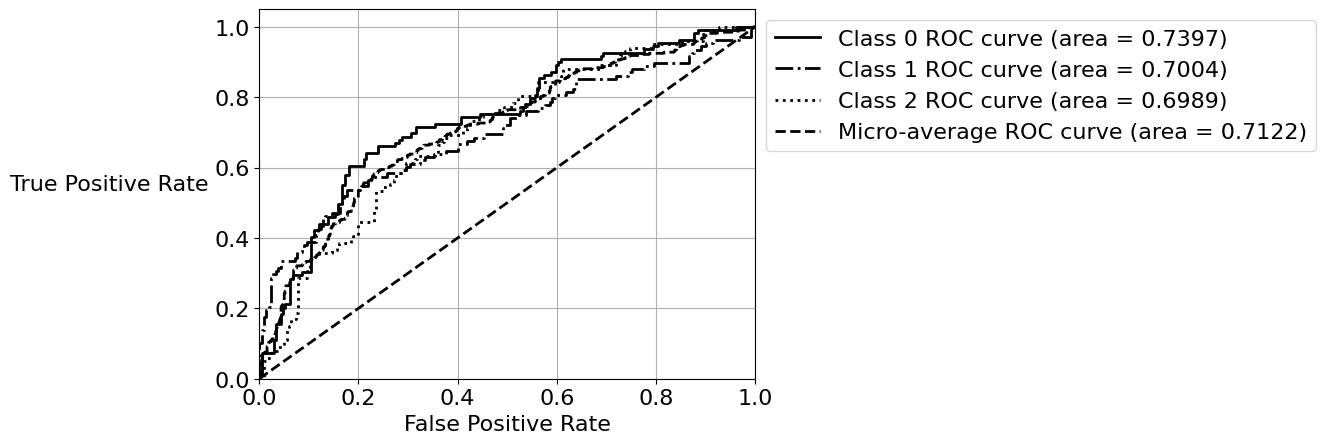

In [7]:
# Running for large number of epochs
weight_decay = 0.00001

Resnet50 = ResNet50(block=Residual_block, in_channels=in_channels, num_classes=num_classes).to(device)
optimizer = torch.optim.SGD(Resnet50.parameters(), lr=lr, momentum=beta, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer,  mode=mode, factor=factor, patience=patience, threshold=threshold, min_lr=min_lr)
_, _ = Resnet50.train_model(train_data=trainloader, test_data=testloader, criterion=torch.nn.CrossEntropyLoss(), optimizer=optimizer, device=device, curve_path=f"{training_directory_path}{model_name}_supervised_epoch_100", scheduler=scheduler, epochs=100)

Resnet50.save_model(f"{models_directory_path}{model_name}_supervised_epoch_100.pth")

all_labels, all_preds, all_probs = evaluate(model=Resnet50, testloader=testloader, device=device)
get_ROC(all_labels=all_labels, all_preds=all_preds, all_probs=all_probs, file=f"../report/report-images/{model_name}_supervised_epoch_100_ROC")
f1 = f1_score(all_labels, all_preds, average='macro')
accuracy = Resnet50.accuracy(testloader, device=device)
conf_matrix = confusion_matrix(all_labels, all_preds)

with open(f"../report/code/{model_name}_supervised_evaluation_epoch_100.txt", 'w') as f:
    f.write(f"F1 Score (Macro): {f1:.4f}\n")
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(conf_matrix, separator=', ') + "\n")
    f.write(f"Accuracy: {accuracy:.4f}\n")

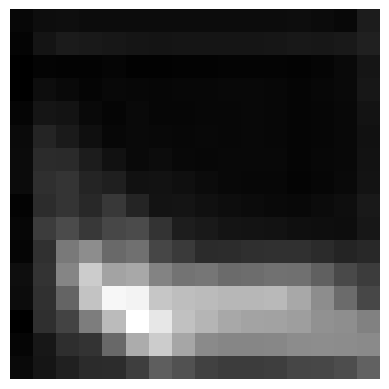

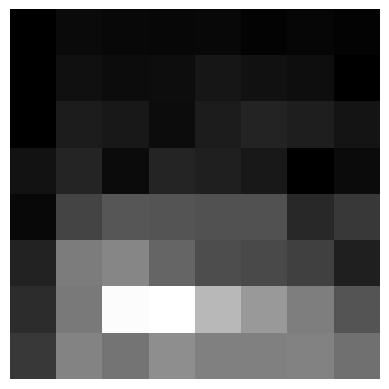

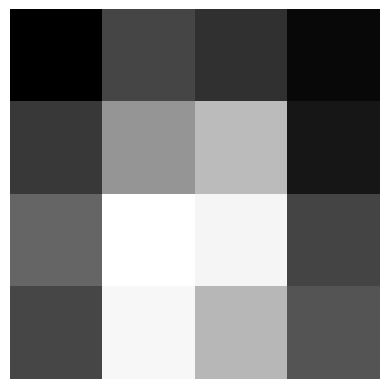

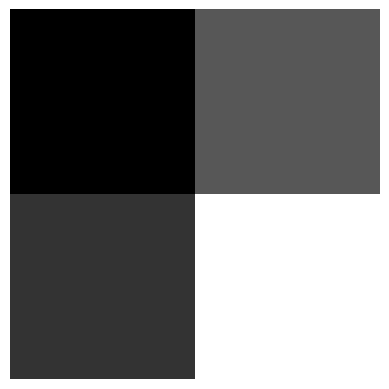

In [8]:
# Get mean layer outputs

# Set model to eval mode
Resnet50.eval()

# Dictionary to store the outputs of each layer
outputs = {}

def hook_fn(module:torch.nn.Sequential, input, output:torch.Tensor, layer_name:str):
    """Hook function to capture the output of a specific layer in a PyTorch model during forward pass.

    Args:
        module (torch.nn.Sequential): The layer (or module) in the PyTorch model for which the output should be captured.
        input: The input to the layer (this argument is required by the hook but is not used in this function).
        output (torch.Tensor): The output from the layer, which will be stored.
        layer_name (str): name of layer to store its outputs.

    Returns:
        None: The function modifies the layer_outputs dictionary in place and does not return any value.

    """    
    outputs[layer_name] = output

# Register hooks to capture the outputs after layers 1-4
Resnet50.layer1.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, "layer1"))
Resnet50.layer2.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, "layer2"))
Resnet50.layer3.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, "layer3"))
Resnet50.layer4.register_forward_hook(lambda module, input, output: hook_fn(module, input, output, "layer4"))

images, labels = next(iter(testloader))
images = images.to(device)

# Run the image through the model
with torch.no_grad():
    Resnet50(images)

# Visualize the outputs of each layer
for layer_name, output in outputs.items():
    # Select the first image's output
    output = output[0]

    # Average across channels to convert to a 2D image (if necessary)
    if output.dim() == 3:  # If output is [C, H, W]
        output = output.mean(dim=0)

    # Normalize the output to [0, 1] for visualization
    output -= output.min()
    output /= output.max()

    # Plot the output
    plt.figure()
    plt.imshow(output.cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.savefig(f"../report/report-images/{model_name}_{layer_name}_supervised_output.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

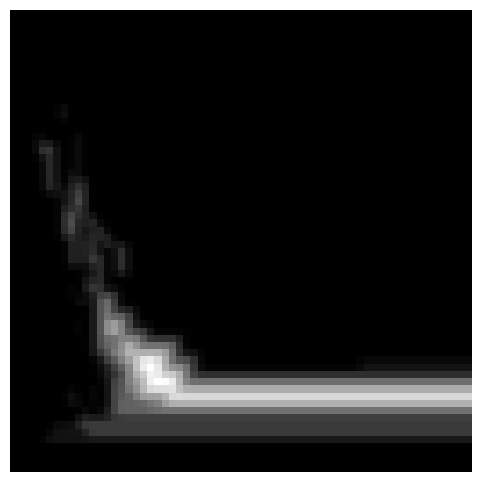

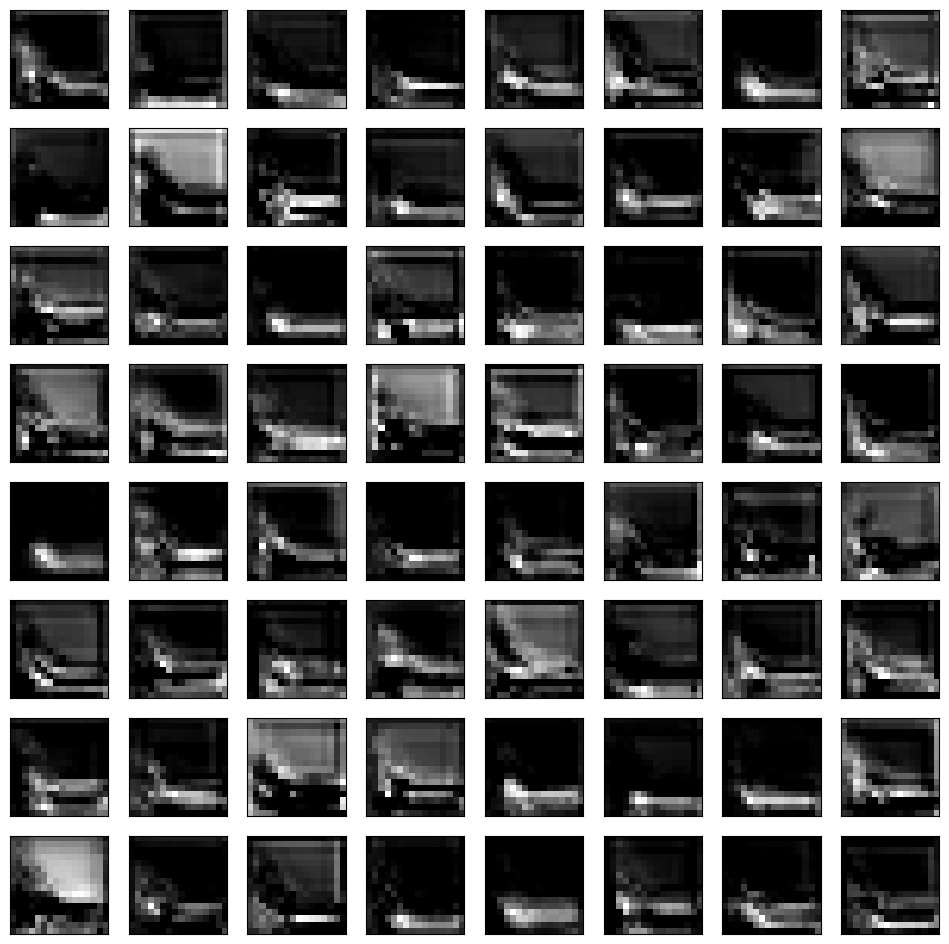

In [15]:
# Get layer 1 feature maps

# Visualize the outputs of each layer
for layer_name, output in outputs.items():
    # Select the first image's output
    output = output[0]
    if layer_name == "layer1":
        break
    
plt.figure(figsize=(6, 6))  # Adjust the size as needed
plt.imshow(images[0].cpu().numpy().squeeze(), cmap='gray')
plt.axis('off')
image_class = int(labels[0].cpu().numpy())
plt.savefig(f"../report/report-images/supervised_example_image_label_{label_dict[image_class]}.pdf", format='pdf', dpi=300, bbox_inches='tight')


# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
plt.figure(figsize=(12, 12))  # Adjust the size as needed
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(output[ix-1, :, :].cpu().numpy(), cmap='gray')
        ix += 1
# show the figure
plt.savefig(f"../report/report-images/{model_name}_{layer_name}_supervised_example_image_label_{label_dict[image_class]}_feature_map.pdf", format='pdf', dpi=300)